In [5]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
# from mayavi import mlab
# mlab.init_notebook()
import glob
# from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
# import shdom
from collections import OrderedDict
from scipy import signal
import itertools
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize
from scipy.optimize import curve_fit
import json

sns.set()
%matplotlib inline

### Load and correct dark noise
First, we load the cover (mean of images of the integrating sphere) and the black cover (mean of images taken at complete darkness). <br>
Next we will subtract the black cover from the cover for the dark noise correction.

(2048, 2448)

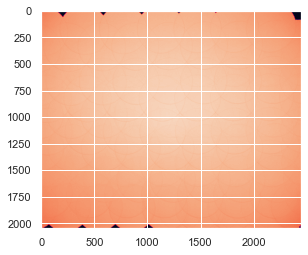

In [14]:
cam_id = 101936
path = "./sample_images"
cover = np.load(f"{path}/cover_{cam_id}.npy")
dark = np.load(f"{path}/dark_{cam_id}.npy")
cover = cover - dark[0]
plt.imshow(cover)
cover.shape

get the fix coeffs per pixel

decompose the cover to the 4 kinds of pixels (0,90,180,270)

In [10]:
covers = []
covers.append(cover[::2,::2])
covers.append(cover[::2,1::2])
covers.append(cover[1::2,::2])
covers.append(cover[1::2,1::2])
covers[0].shape


(1024, 1224)

fit a curve for each cover

In [4]:
models = []
for cov in covers:
    x = []
    y = []
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            if cov[i,j]>300:
                x.append((i,j))
                y.append(cov[i,j])
    x = np.array(x)
    y = np.array(y)
    polynomial_features= PolynomialFeatures(degree=6)
    x_poly = polynomial_features.fit_transform(x)
    model = linear_model.LinearRegression()
    model.fit(x_poly, y)
    models.append(model)
    y_poly_pred = model.predict(x_poly)
    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    print(rmse)


27.13267564452344
24.262246744054707
29.19585604262648
24.161904883050163


plot the x and y axis with the "predictions" of our curve to estimate the fit.

(1224, 28)
2406.2966865897993


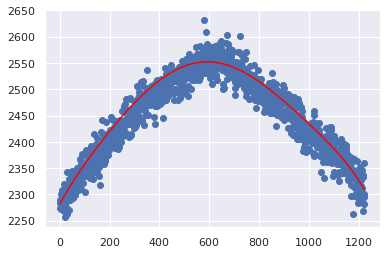

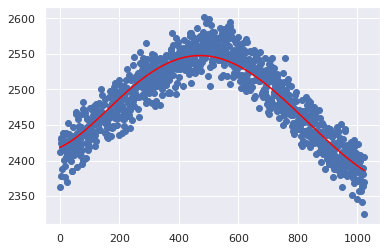

(1224, 28)
2549.9977745096703


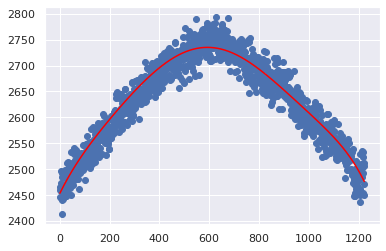

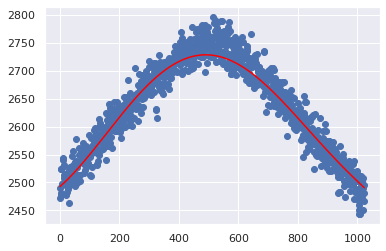

(1224, 28)
2548.5561092623566


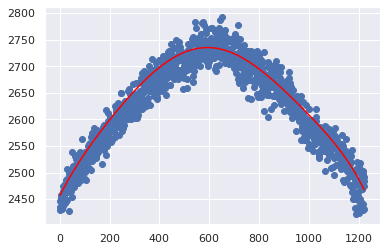

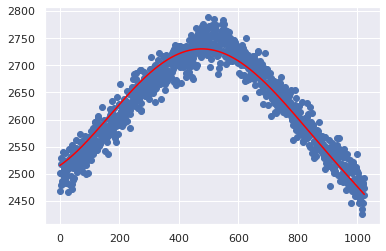

(1224, 28)
2554.5278475084415


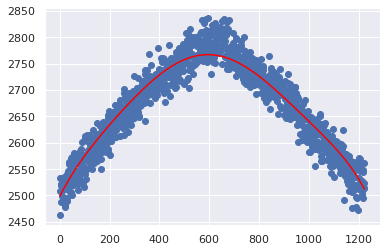

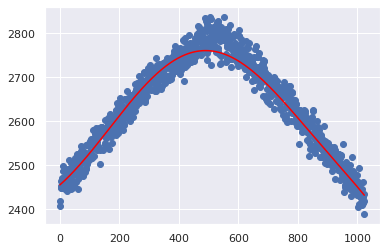

In [6]:
for cov, model in zip(covers,models):
    x_poly = polynomial_features.fit_transform(np.column_stack([np.full(len(cov[1024//2]),512),np.arange(1224)]))
    print(x_poly.shape)
    print(np.mean(cov[cov>300]))
    plt.scatter(range(2448//2), cov[1024//2,:])
    plt.plot(range(2448//2) , model.predict(x_poly), color='red')
    plt.show()
    x_poly = polynomial_features.fit_transform(np.column_stack([np.arange(1024),np.full(len(cov[:,1224//2]),512)]))

    plt.scatter( range(2048//2),cov[:,1224//2])
    plt.plot(range(2048//2) , model.predict(x_poly), color='red')
    plt.show()


sanity check: if our image polarized we should see 4 "hills" at the histogram.

(array([[ 359., 1689.,    0., ...,    0.,    0.,    0.],
        [   7.,    0.,    0., ..., 1306.,  525.,    0.],
        [ 176., 1782.,   90., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ..., 1038.,  957.,    0.],
        [  47., 2001.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ..., 1193.,  769.,    0.]]),
 array([  -2.29      ,  209.63284783,  421.55569565,  633.47854348,
         845.4013913 , 1057.32423913, 1269.24708696, 1481.16993478,
        1693.09278261, 1905.01563043, 2116.93847826]),
 <a list of 2448 BarContainer objects>)

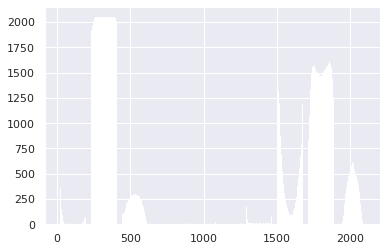

In [7]:
plt.hist(cover)

OPTIONAL: complete missing pixels with the fitted model.

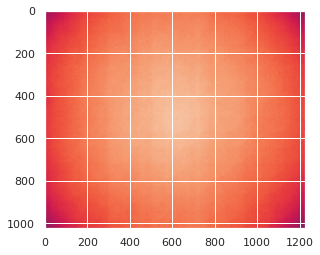

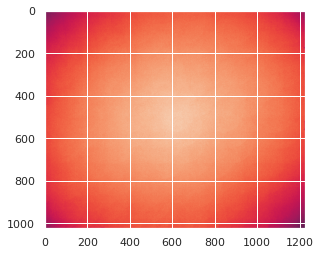

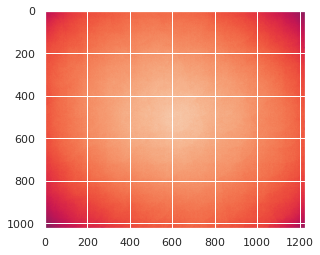

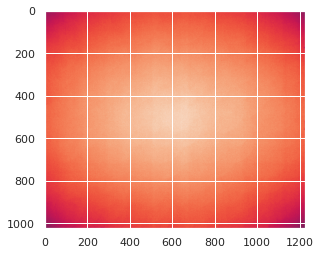

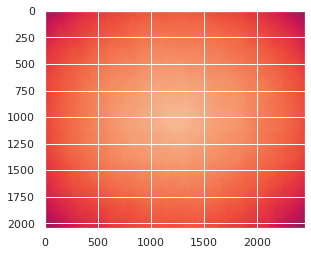

In [8]:
for cov, model in zip(covers, models):
    x = []
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            if cov[i,j]<500:
                x.append((i,j))
    if len(x) > 0:
        x = np.array(x)
        polynomial_features= PolynomialFeatures(degree=6)
        x_poly = polynomial_features.fit_transform(x)
        predictions = model.predict(x_poly)
        for (i,j) , prediction in zip(x, predictions):
            cov[i,j] = prediction
    plt.imshow(cov)
    plt.show()

cover[::2,::2] = covers[0]
cover[::2,1::2] = covers[1]
cover[1::2,::2] = covers[2]
cover[1::2,1::2] = covers[3]
plt.imshow(cover)
plt.show()

## Compute the matrice for the flat-field correction such that if we multiply it with the cover elementwise we get all the values to be the mean value of the original cover.

3104.123616848129
-9.675


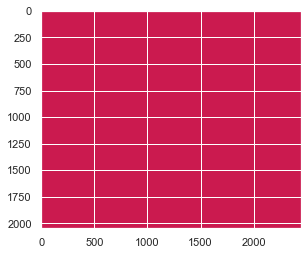

In [11]:
mean = np.mean(cover)
print(mean)
print(np.min(cover))
cover_fix = np.full(cover.shape, mean)/cover
plt.imshow(cover*cover_fix)
plt.show()

In [10]:
cover*cover_fix

array([[2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089],
       [2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089],
       [2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089],
       ...,
       [2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089],
       [2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089],
       [2514.84436089, 2514.84436089, 2514.84436089, ..., 2514.84436089,
        2514.84436089, 2514.84436089]])

## Save all of the parameters for the current camera.

In [12]:
# the covers are in that form : 1  2
#                               3  4
data = {"name": f"{cam_id}",
            "exposure time": 3000,
            "integrating sphere DN": 5000,
            "distance integrating sphere to camera lens (cm)": 79,
            "fixer image": cover_fix.tolist(),
            "I_dark" : dark[0].tolist(),}
            #"C" : C}
with open(f"{cam_id}_calibration_params.json", "w") as file:
    json.dump(data, file)